### Import required libraries

In [50]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats

### Setup plotting style

In [51]:
# Use a compatible matplotlib style and seaborn settings
plt.style.use('default')  # Use default matplotlib style
sns.set_theme(style="darkgrid")  # Modern seaborn theme setting
sns.set_palette("husl")
%matplotlib inline

# Additional styling for better plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

### Load the data

In [52]:
'''
    Test Case 1:
          - Train client is a Laptop connected to 5G network
          - Web client is a Laptop connected to 5G network
'''
filename =  './29_08_2025/pre_processed/processed_Train_Client(Laptop)_Web_Client(Laptop)_e1c07b43-9e1e-4438-ade8-a320a030e494_Latency.json'


'''
    Test Case 2:
          - Train client is a Laptop connected to 5G network
          - Web client is a Phone connected to 5G network
'''
#filename =  './29_08_2025/pre_processed/processed_Train_Client(Laptop)_Web_Client(Mobile_DE)_5d6a5a85-6566-45b9-8b57-48e886539e0b_Latency.json'


'''
    Test Case 3:
          - Train client is a Laptop connected to 5G network (Germany)
          - Web client is a Phone connected to 5G network (Bangladesh)
'''
#filename =  './29_08_2025/pre_processed/processed_Train_Client(Laptop)_Web_Client(Mobile_BD)_1bdb4d47-a2e0-4148-a721-796cf6ff755b_Latency.json'



with open(filename, 'r') as file:
    data = json.load(file)

print(f"Data loaded successfully from {filename}")
print(f"Data type: {type(data)}")
print(f"Data keys: {list(data.keys()) if isinstance(data, dict) else 'Not a dictionary'}")

# Convert to DataFrames for easier analysis
telemetry_df = pd.DataFrame(data['telemetryLatencies'])
video_df = pd.DataFrame(data['videoLatencies'])

# Create a summary DataFrame from statistics
protocols = ['websocket', 'webtransport', 'mqtt']
stats_data = []
for protocol in protocols:
    stats_data.append({
        'protocol': protocol,
        'count': data['statistics'][protocol]['count'],
        'avg': data['statistics'][protocol]['avg'],
        'min': data['statistics'][protocol]['min'],
        'max': data['statistics'][protocol]['max']
    })
stats_df = pd.DataFrame(stats_data)

Data loaded successfully from ./29_08_2025/pre_processed/processed_Train_Client(Laptop)_Web_Client(Laptop)_e1c07b43-9e1e-4438-ade8-a320a030e494_Latency.json
Data type: <class 'dict'>
Data keys: ['exportTime', 'statistics', 'telemetryLatencies', 'videoLatencies', 'processingTime', 'originalFile']


#### 1.1 Basic Statistics Comparison

In [53]:
print("Protocol Statistics Comparison:")
print(stats_df)

Protocol Statistics Comparison:
       protocol  count         avg   min     max
0     websocket    260  141.911538  48.5  2534.5
1  webtransport    232  135.443966  49.5  2424.5
2          mqtt    262   81.320611  30.5  2355.5


#### 1.2 Visualization of protocol performance

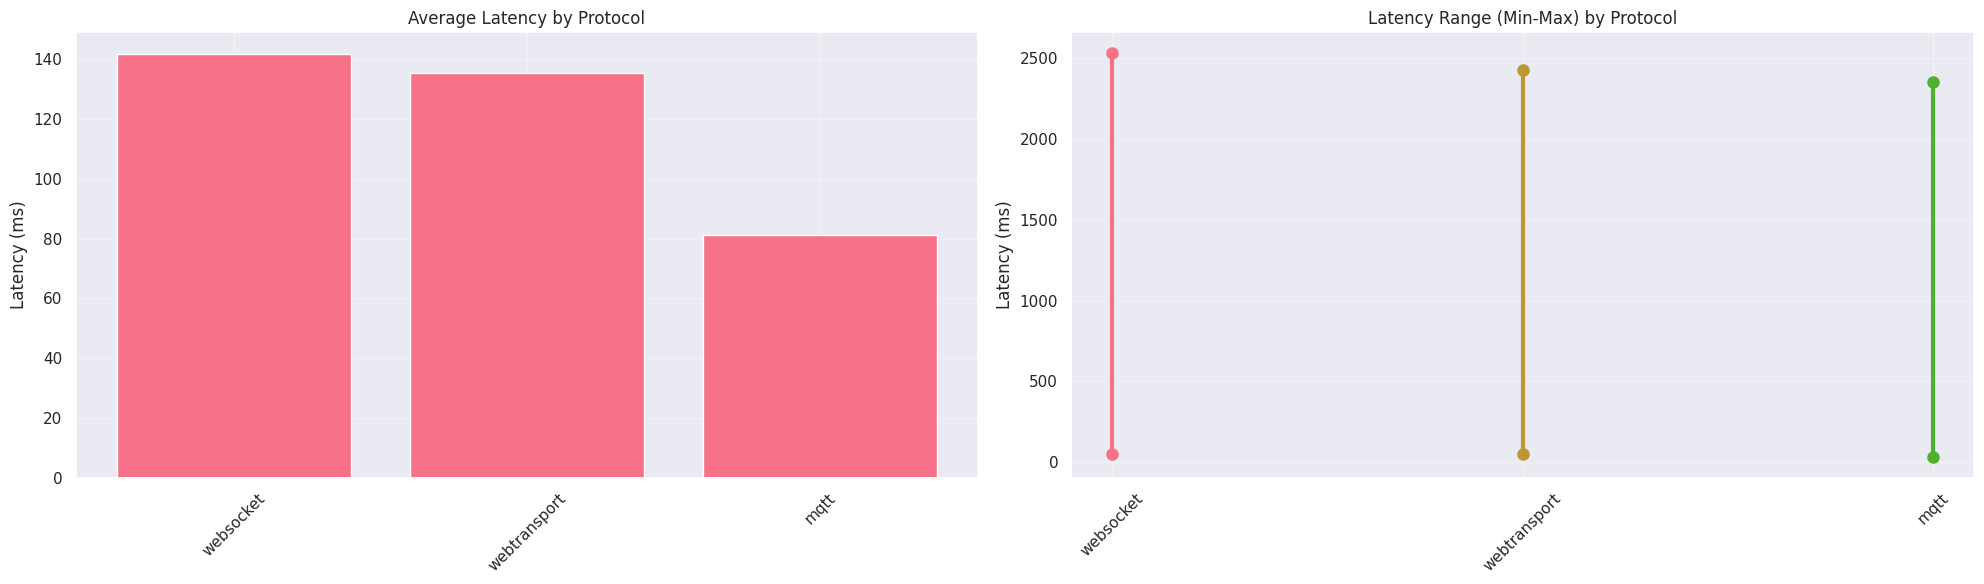

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Average latency by protocol
axes[0].bar(stats_df['protocol'], stats_df['avg'])
axes[0].set_title('Average Latency by Protocol')
axes[0].set_ylabel('Latency (ms)')
axes[0].tick_params(axis='x', rotation=45)

# Min-Max latency range
for i, row in stats_df.iterrows():
    axes[1].plot([row['protocol'], row['protocol']], [row['min'], row['max']],
                   marker='o', linewidth=3, markersize=8)
axes[1].set_title('Latency Range (Min-Max) by Protocol')
axes[1].set_ylabel('Latency (ms)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### 2.1 Time Series analysis of telemetry data

In [55]:
# Check for missing values in telemetry data
print("Missing values in telemetry data:")
print(f"MQTT: {telemetry_df['mqtt'].isna().sum()}")
print(f"WebTransport: {telemetry_df['wt'].isna().sum()}")
print(f"WebSocket: {telemetry_df['ws'].isna().sum()}")

# Check data shape and info
print(f"\nTelemetry data shape: {telemetry_df.shape}")
print(f"Sequence ID range: {telemetry_df['sequence_id'].min()} - {telemetry_df['sequence_id'].max()}")

# Display first few rows to understand the data structure
print("\nFirst 10 rows of telemetry data:")
print(telemetry_df.head(10))

Missing values in telemetry data:
MQTT: 67
WebTransport: 97
WebSocket: 69

Telemetry data shape: (329, 4)
Sequence ID range: 79 - 343

First 10 rows of telemetry data:
   sequence_id   mqtt     wt     ws
0           79   52.5   70.5   90.5
1           80   52.5   66.5  100.5
2           81   39.5  127.5  160.5
3           82  182.5  196.5  186.5
4           83   40.5   98.5   91.5
5           84   36.5  127.5  137.5
6           85   40.5  119.5    NaN
7           86   44.5  128.5    NaN
8           87   47.5    NaN  263.5
9           88   39.5    NaN  152.5


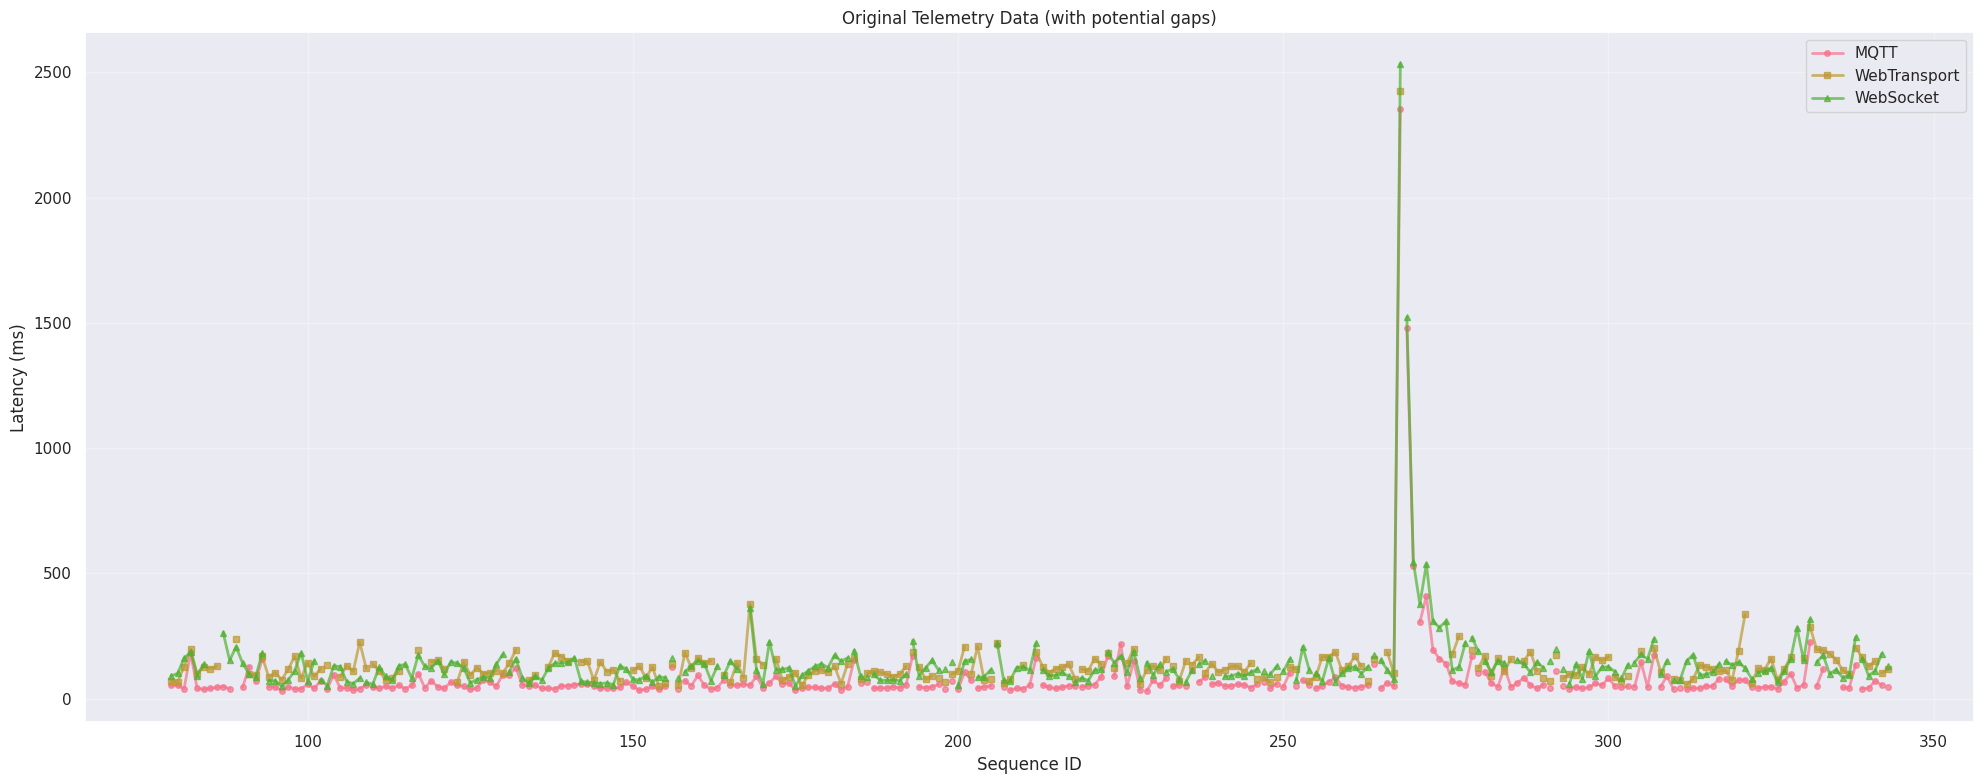

In [56]:
# Comparison: Original data with gaps vs Interpolated data
fig, ax1 = plt.subplots(1, 1, figsize=(20, 8))

# Original data (with potential gaps)
ax1.plot(telemetry_df['sequence_id'], telemetry_df['mqtt'], marker='o', label='MQTT', linewidth=2, markersize=4, alpha=0.7)
ax1.plot(telemetry_df['sequence_id'], telemetry_df['wt'], marker='s', label='WebTransport', linewidth=2, markersize=4, alpha=0.7)
ax1.plot(telemetry_df['sequence_id'], telemetry_df['ws'], marker='^', label='WebSocket', linewidth=2, markersize=4, alpha=0.7)
ax1.set_xlabel('Sequence ID')
ax1.set_ylabel('Latency (ms)')
ax1.set_title('Original Telemetry Data (with potential gaps)')
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 2.2 Cumulative Latency Analysis for telemetry data

In [57]:
# Create cumulative latency data with interpolation for null values
telemetry_clean_cumulative = telemetry_df.copy()

# First, interpolate null values for each protocol
print("Before interpolation:")
print(f"MQTT null values: {telemetry_clean_cumulative['mqtt'].isna().sum()}")
print(f"WebTransport null values: {telemetry_clean_cumulative['wt'].isna().sum()}")
print(f"WebSocket null values: {telemetry_clean_cumulative['ws'].isna().sum()}")

# Interpolate missing values using linear interpolation
telemetry_clean_cumulative['mqtt'] = telemetry_clean_cumulative['mqtt'].interpolate(method='linear')
telemetry_clean_cumulative['wt'] = telemetry_clean_cumulative['wt'].interpolate(method='linear')
telemetry_clean_cumulative['ws'] = telemetry_clean_cumulative['ws'].interpolate(method='linear')

print("\nAfter interpolation:")
print(f"MQTT null values: {telemetry_clean_cumulative['mqtt'].isna().sum()}")
print(f"WebTransport null values: {telemetry_clean_cumulative['wt'].isna().sum()}")
print(f"WebSocket null values: {telemetry_clean_cumulative['ws'].isna().sum()}")

# Calculate cumulative latencies for each protocol
telemetry_clean_cumulative['mqtt_cumulative'] = telemetry_clean_cumulative['mqtt'].cumsum()
telemetry_clean_cumulative['wt_cumulative'] = telemetry_clean_cumulative['wt'].cumsum()
telemetry_clean_cumulative['ws_cumulative'] = telemetry_clean_cumulative['ws'].cumsum()

print("\nCumulative latency data created successfully!")
print(f"Shape: {telemetry_clean_cumulative.shape}")
print("\nFirst 10 rows of cumulative data:")
print(telemetry_clean_cumulative[['sequence_id', 'mqtt_cumulative', 'wt_cumulative', 'ws_cumulative']].head(10))
print("\nLast 10 rows of cumulative data:")
print(telemetry_clean_cumulative[['sequence_id', 'mqtt_cumulative', 'wt_cumulative', 'ws_cumulative']].tail(10))

Before interpolation:
MQTT null values: 67
WebTransport null values: 97
WebSocket null values: 69

After interpolation:
MQTT null values: 0
WebTransport null values: 0
WebSocket null values: 0

Cumulative latency data created successfully!
Shape: (329, 7)

First 10 rows of cumulative data:
   sequence_id  mqtt_cumulative  wt_cumulative  ws_cumulative
0           79             52.5      70.500000           90.5
1           80            105.0     137.000000          191.0
2           81            144.5     264.500000          351.5
3           82            327.0     461.000000          538.0
4           83            367.5     559.500000          629.5
5           84            404.0     687.000000          767.0
6           85            444.5     806.500000          946.5
7           86            489.0     935.000000         1168.0
8           87            536.5    1100.166667         1431.5
9           88            576.0    1302.000000         1584.0

Last 10 rows of cumulative

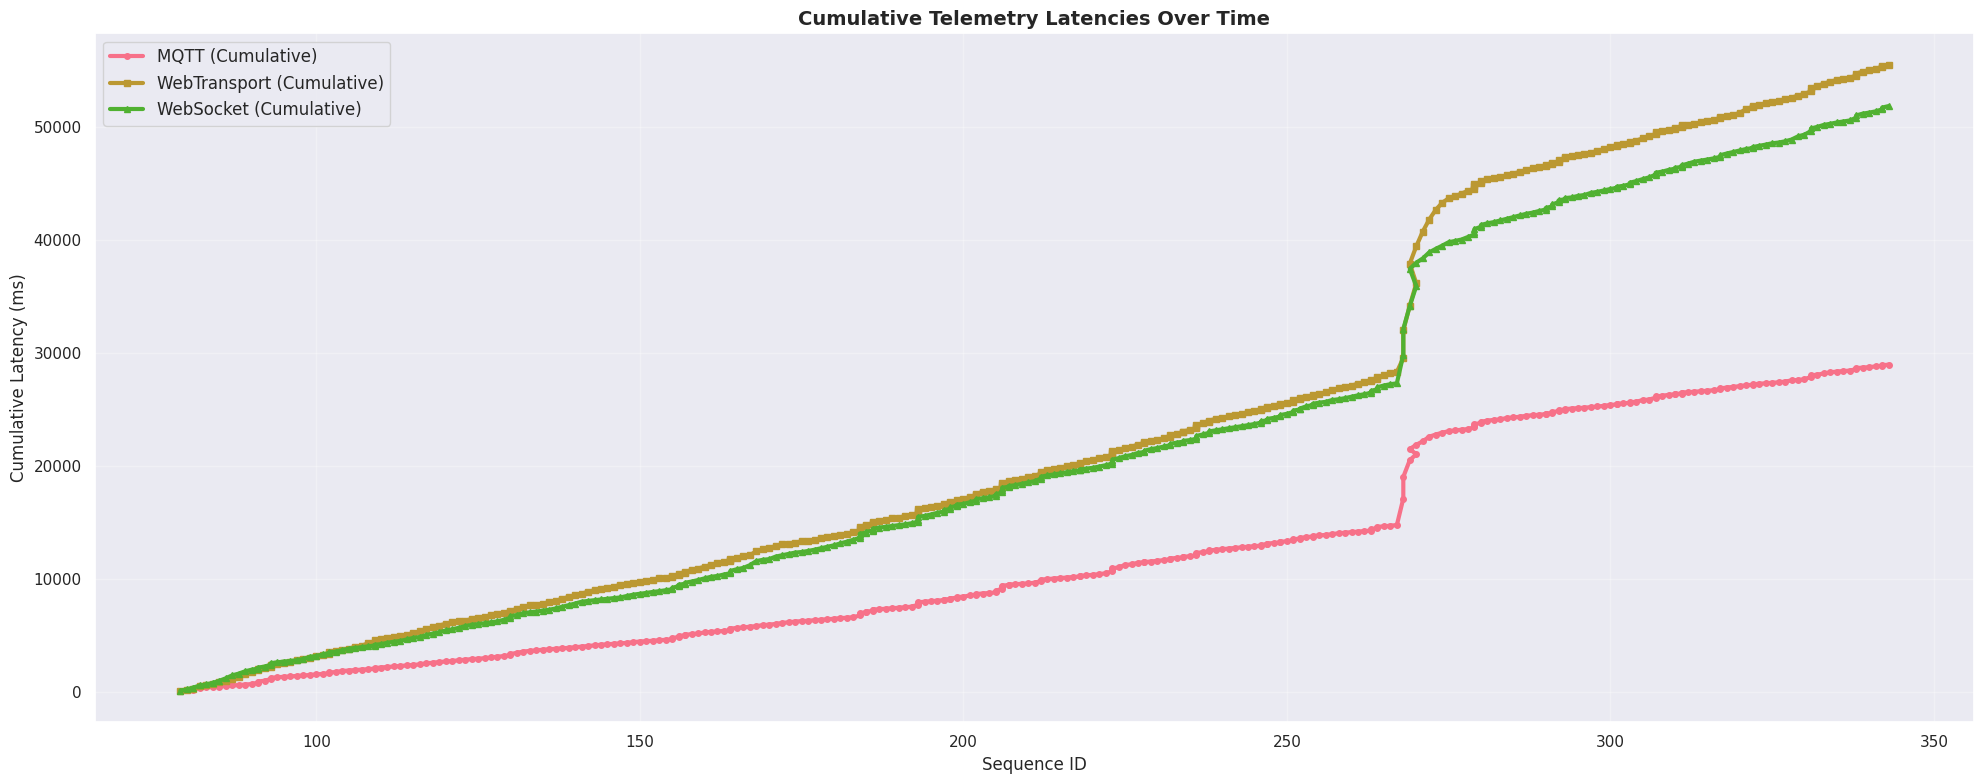

In [58]:
# Plot cumulative latencies
plt.figure(figsize=(20, 8))
plt.plot(telemetry_clean_cumulative['sequence_id'], telemetry_clean_cumulative['mqtt_cumulative'],
         marker='o', label='MQTT (Cumulative)', linewidth=3, markersize=4)
plt.plot(telemetry_clean_cumulative['sequence_id'], telemetry_clean_cumulative['wt_cumulative'],
         marker='s', label='WebTransport (Cumulative)', linewidth=3, markersize=4)
plt.plot(telemetry_clean_cumulative['sequence_id'], telemetry_clean_cumulative['ws_cumulative'],
         marker='^', label='WebSocket (Cumulative)', linewidth=3, markersize=4)

plt.xlabel('Sequence ID', fontsize=12)
plt.ylabel('Cumulative Latency (ms)', fontsize=12)
plt.title('Cumulative Telemetry Latencies Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### 3. Video Frame Latency Analysis

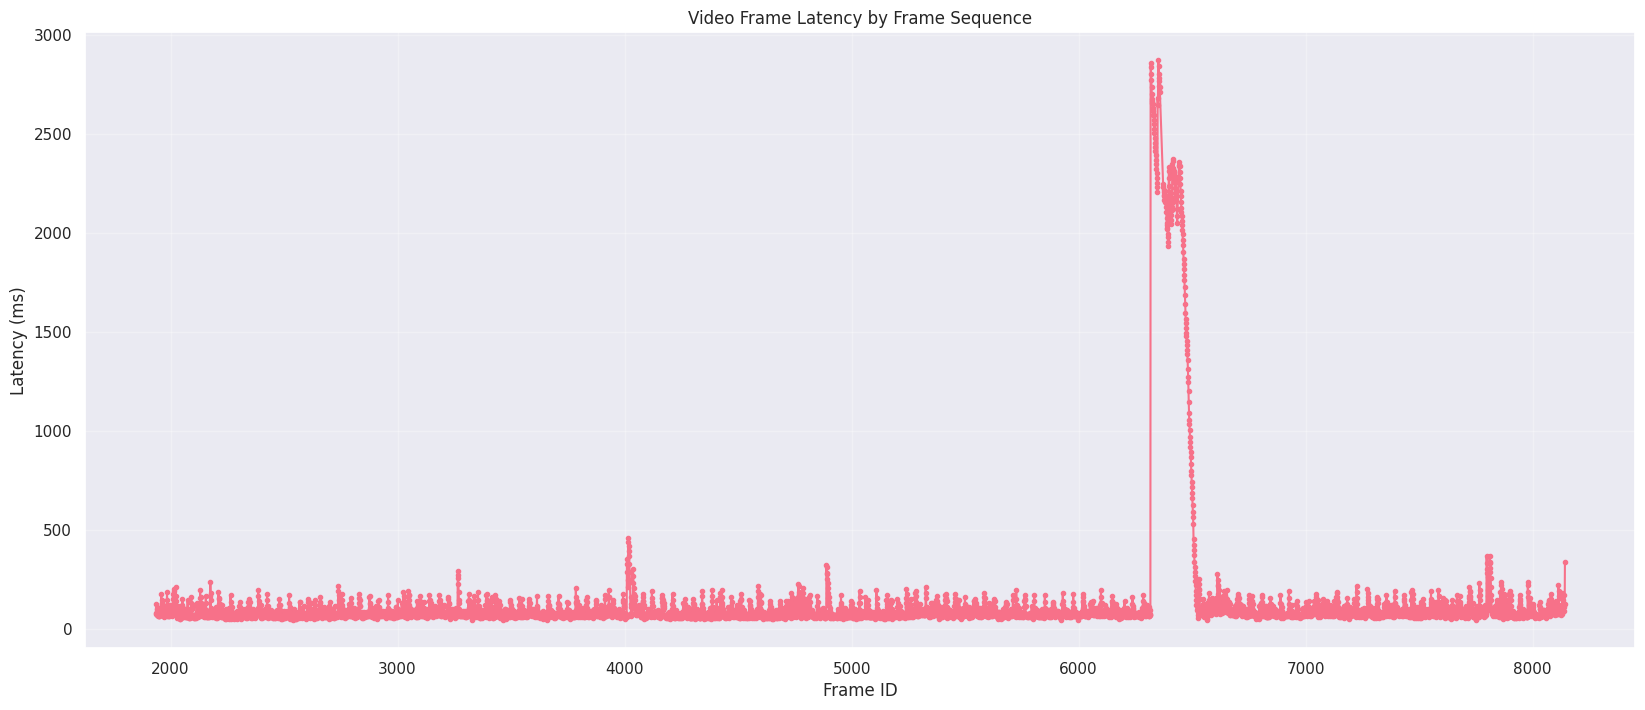

In [59]:
# 3.1 Time series analysis of video latencies
plt.figure(figsize=(20, 8))

# Latency over frame sequence
plt.plot(video_df['frameId'], video_df['latency'], marker='o', markersize=3)
plt.xlabel('Frame ID')
plt.ylabel('Latency (ms)')
plt.title('Video Frame Latency by Frame Sequence')
plt.grid(True, alpha=0.3)
plt.show()